In [42]:
# Imports. Nothing to see here.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import RegexpTokenizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import GridSearchCV

import sqlite3
from textblob import TextBlob
from wordcloud import WordCloud

import pickle

# Our Multi Model Project!

The overall goal of this project is to approach modeling a dataset from several fronts using different models. We will create two models based on Natural Language Processing to predict ratings on data points in our data set. Then we'll create a recomender system to offer options to users based on their preferences. Part one of the process, this notebook, will start by exploring our large dataset of podcasts. Relevant information included in the dataset are written and numerically rated reviews. After investigating the dataset as is, we will attempt to create a model to predict the numerical rating based on the text of the written reviews. After that step, we will eliminate all of the data correctly identified on the first pass and create a new dataset comprising solely of misclassified or hard to predict data. Part 2 of this notebook will deal with the misclassified data.

In [43]:
# Kaggle database contains three tables: 'categories', 'podcasts', 'reviews', and 'runs'
# 'runs' is a collection of metadata and will not be used.

cnx = sqlite3.connect('D:\Flatiron\Capstone\database.sqlite')

data = pd.read_sql_query("SELECT * FROM podcasts p JOIN categories c USING (podcast_id) JOIN reviews r USING (podcast_id)", cnx)

In [44]:
data.head(2)

podcast_id   itunes_id                        slug  \
0  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   
1  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   

                                          itunes_url  \
0  https://podcasts.apple.com/us/podcast/backstag...   
1  https://podcasts.apple.com/us/podcast/backstag...   

                        title              category                title  \
0  Backstage at Tilles Center                  arts  really interesting!   
1  Backstage at Tilles Center  arts-performing-arts  really interesting!   

                                             content  rating  \
0  Thanks for providing these insights.  Really e...       5   
1  Thanks for providing these insights.  Really e...       5   

                  created_at  
0  2018-04-24T12:05:16-07:00  
1  2018-04-24T12:05:16-07:00

In [45]:
#Investigate the data.

print('(Columns, Rows)' , data.shape)
print('Total number of podcasts: ', data['podcast_id'].nunique())
print('Total number of missing values: \n', data.isna().sum(),'\n')

a = len(data)
data = data.drop_duplicates()
b = len(data)
print('# Number of duplicate rows dropped: {}'.format(a-b),'\n')

print(data.info())

(Columns, Rows) (1425165, 10)
Total number of podcasts:  46665
Total number of missing values: 
 podcast_id    0
itunes_id     0
slug          0
itunes_url    0
title         0
category      0
title         0
content       0
rating        0
created_at    0
dtype: int64 

# Number of duplicate rows dropped: 642 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424523 entries, 0 to 1425164
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   podcast_id  1424523 non-null  object
 1   itunes_id   1424523 non-null  int64 
 2   slug        1424523 non-null  object
 3   itunes_url  1424523 non-null  object
 4   title       1424523 non-null  object
 5   category    1424523 non-null  object
 6   title       1424523 non-null  object
 7   content     1424523 non-null  object
 8   rating      1424523 non-null  int64 
 9   created_at  1424523 non-null  object
dtypes: int64(2), object(8)
memory usage: 119.6+ MB
None


5    1267911
1      60495
4      41652
3      29023
2      25442
Name: rating, dtype: int64


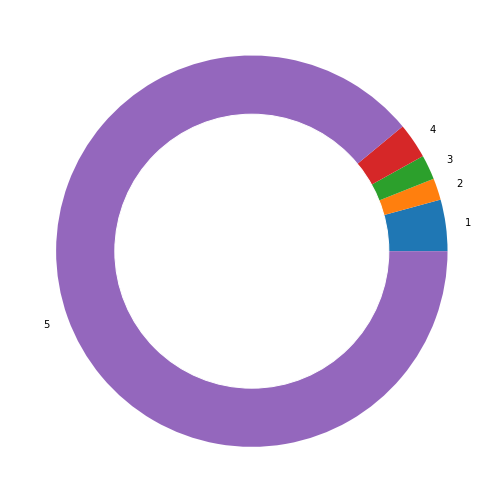

In [46]:
# Thanks to StackOverflow for this cool donut chart! Basically a pie chart with a blank circle placed in the center but it's so much cleaner this way.

print(data['rating'].value_counts())

plt.figure(figsize=(15,9))

# create data
size_of_groups=[60381,25419,29006,41631,1265761]
 
# Create a pieplot
plt.pie(size_of_groups, labels=[1,2,3,4,5])
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()

# Natural Language Processing

Here we begin analyzing the text contained in the reviews. This text will be collected in a TF-IDF matrix and used to predict the numerical reviews the user provides.

In [47]:
# Start NLP by identifying stopwords.

tokenizer = RegexpTokenizer(r'\w+')

stops = stopwords.words('english')
stops += list(string.punctuation)
stops += ['podcast', 'listen', 'listening']

In [48]:
# Reformat some columns to make it easier to process.

data ['slug'] = data['slug'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.split()[0])

In [49]:
# Here's the NLP good stuff!
# Tokenize texts into its base content.

data['content'] = data['content'].apply(tokenizer.tokenize)

data['content'] = data['content'].apply(lambda x: [word.lower() for word in x if word.lower() not in stops])

In [50]:
# Functionalize our next step.

def lemmatize():
    data['lemm'] = data['content'].apply(lemmatize_text)
    data['lemm'] = data['lemm'].apply(lambda x: ' '.join(x))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [51]:
# Lemmatize our words to simplify our corpus.

lemmatize()

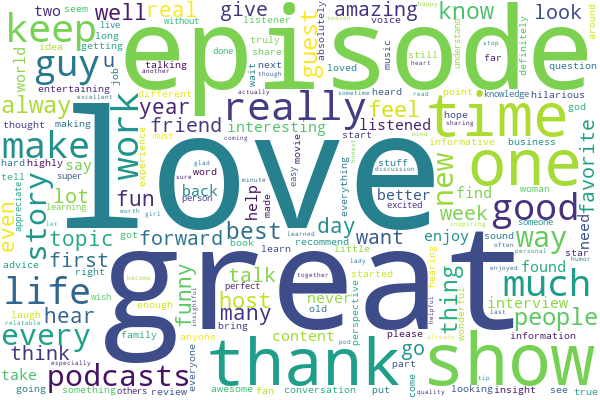

In [52]:
# Create a word cloud to visualize our common text.

long_string = ','.join(list(data['lemm'].values))
wordcloud = WordCloud(background_color="white", max_words=200, height=400, width=600,                                   contour_width=3, contour_color='steelblue', collocations=False)
wordcloud.generate(long_string)
wordcloud.to_image()

Our word cloud is overwhelmingly positive. This is to be expected when the dataset is so heavily imbalanced in such a positive manner. Unfortunately it renders the word cloud not very informative.

In [53]:
# Let's use TextBlob to check out the sentiment of our data.

polarity = (lambda x: TextBlob(x).sentiment.polarity)
subjectivity = (lambda x: TextBlob(x).sentiment.subjectivity)

data['polarity'] = data['lemm'].apply(polarity)
data['subjectivity'] = data['lemm'].apply(subjectivity)

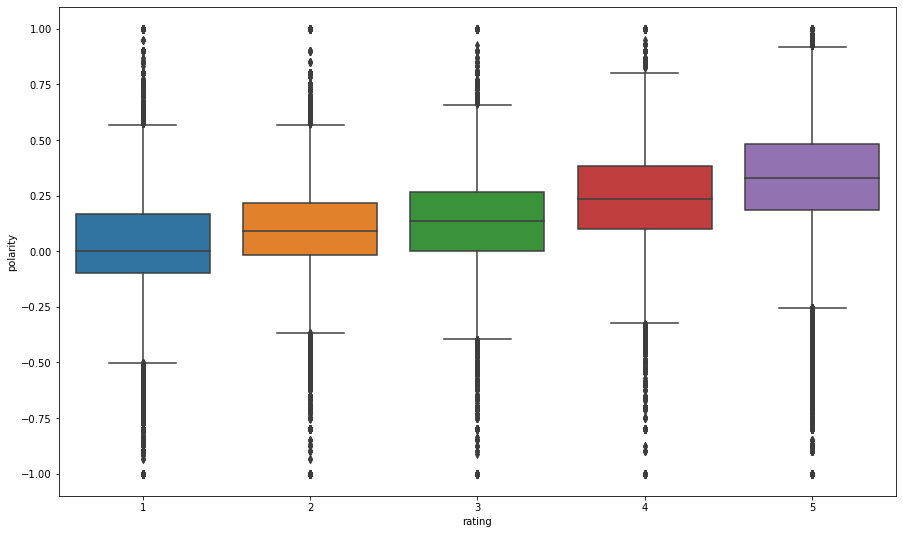

In [54]:
# Plot the TextBlob polarity.

plt.figure(figsize=(15,9))
sns.boxplot(data['rating'],data['polarity'])
plt.show()

A number of observations come from this boxplot. A high number of outliers are unsurprising given the size of the dataset. Seeing both extremes of polarity represented on every rating is a little surprising. It suggests two things: 1. Our NLP methods may be having a hard time interpreting some entries, like the difference between 'good' and 'not good.' 2. Some user error may be involved, with poor written reviews being matched with high numerical reviews. In both cases, further insight into the data may yield positive results.

The Interquartile range, or middle 50%, of each rating is roughly the same size with rating '2' being a little smaller than the rest. This indicates a normal distribution across each rating. The median of each rating is progressively higher at what looks to be a linear rate. This is to be expected in a metric so strongly correlated to its positivity.

What is striking is how slight the raise is between neighboring ratings. This reflects the real world in which my opinion of an item being a 3 vs a 4 is pretty narrow. The wider the gap between ratings, the larger the gap in polarity, as would be expected in a real world situation.

In [55]:
# We instantiate the TF-IDF Vectorizer. First we fit the data, then we pickle the data, then transform the data to our current dataset. It's important to pickle between so we can transform the vectorizer to new data later.

tfidf = TfidfVectorizer()
tf = tfidf.fit(data['lemm'])

pickle.dump(tf, open("tf.p", "wb" ))

tf = tfidf.transform(data['lemm'])

In [64]:
# We model the data using Logistic Regression. Normally not the best model for a multiclass classification such as our use, but the results exceed expectations. Then we use the model to predict our data and create a new column in our DataFrame.

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
pickle.dump(clf, open('clf', 'wb'))
clf.fit(tf, data['rating'])
data['predict'] = clf.predict(tf)

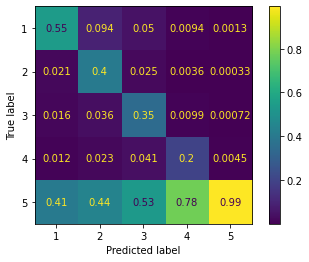

In [57]:
# Inspect our results and prepare for the next step.

plot_confusion_matrix(clf, tf, data['rating'], normalize='pred')

Our confusion matrix is interesting. Our worst performing rating is '4.' Not surprising, as noted before a '4' is close to a '5.' In fact, our whole model is generally either predicting class '5' or a higher class than actual. Considering our imbalanced dataset, this makes sense. 

If you consider ratings that were misclassified within a margin of error of 1, the confusion matrix is showing at least a 60% success rate per rating and 70% for our next score.

In [58]:
# Let's make a new dataset consisting only of datapoints our model got wrong.

filtered = data[data['rating'] != data['predict']]

In [59]:
new_size = 1-(filtered.shape[0] / data.shape[0])

print(filtered['rating'].value_counts().sort_index())
print('\n', 'Our misclassified data set is {:.2%} smaller.'.format(new_size))

1     11021
2      4568
3      5676
4      9722
5    218837
Name: rating, dtype: int64

 Our misclassified data set is 82.46% smaller.


In [60]:
# Calculate our average error per data point.

(np.array(filtered['rating']) - np.array(filtered['predict'])).mean()

1.5714943320097348

In [61]:
# % of total ratings that were misclassified per rating.

np.array(filtered['rating'].value_counts().sort_index()) / np.array(data['rating'].value_counts().sort_index())

array([0.18218035, 0.17954563, 0.19556903, 0.23341016, 0.1725965 ])

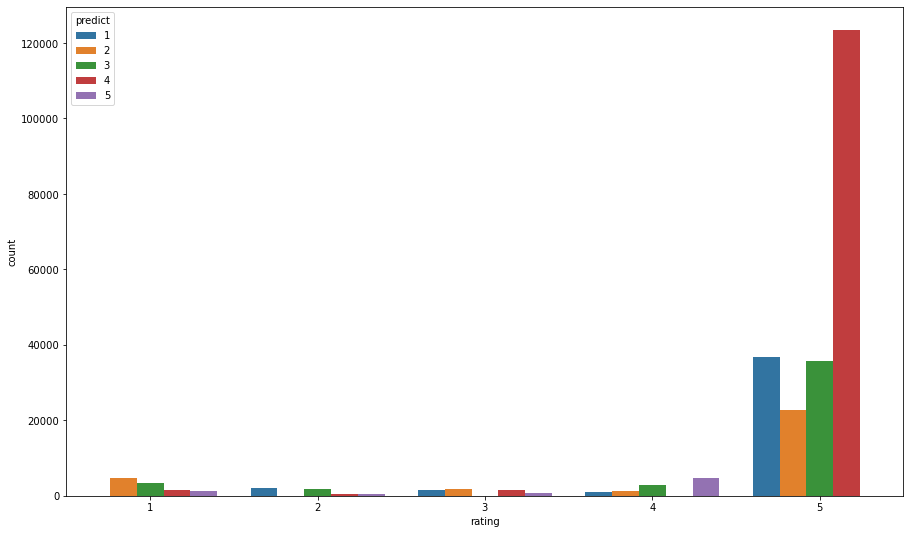

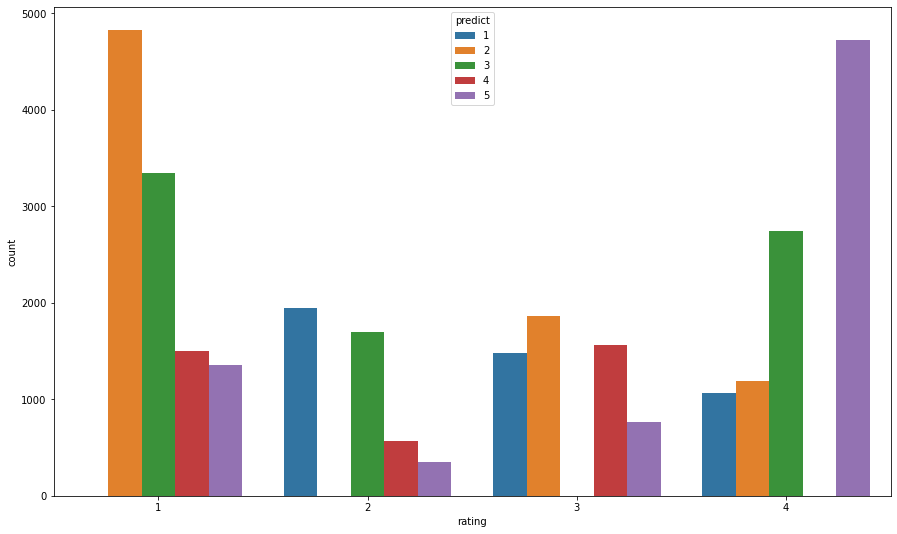

In [62]:
# Inspecting our misclassified data by misclassification.
# Our first attempt reveals, like before, huge imbalance making most of the chart difficult to interpret. Our second attempt works well using all data points that are not '5.'

plt.figure(figsize=(15,9))
sns.countplot(x='rating', hue = 'predict', data=filtered)
plt.show()

not5 = filtered[filtered['rating'] <= 4]
plt.figure(figsize=(15,9))
sns.countplot(x='rating', hue = 'predict', data=not5)
plt.show()

Inspecting these prediction graphs shows what our confusion matrix told us: when the model was wrong, it was often very close with most predictions being within one rating of the actual. We will take this knowledge with us into part 2 of our EDA.

In [63]:
# Pickling our data sets and model for part 2 of our EDA.

filtered.to_pickle('./filtered')
data.to_pickle('./data')